LSTM Stock Predictor 
Data Preparation
In this section, we will prepare the training and testing data for the LSTM model.

Using the window_data function to generate the X and y values for the model.
Split the data into 70% training and 30% testing
Apply the MinMaxScaler to the X and y values
Reshape the X_train and X_test data for the model.
Note: The required input format for the LSTM is: reshape((X_train.shape[0], X_train.shape[1], 1))


In [47]:
# Import libraries and dependencies
!pip install alpaca_trade_api

# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [19]:
# Load .env enviroment variables
#from dotenv import load_dotenv
#load_dotenv()

# Set Alpaca API key and secret
#alpaca_api_key = os.getenv("ALPACA_API_KEY")
#alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

alpaca_api_key = 'AKRU2788FFAG4PTQ3BR1'
alpaca_secret_key = 'ItFLWJ3MWxmgB1gmFVWkgApGhQj41zLTDtqY1OuN'

api = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version = "v2"
)

### Data Loading

In this activity, we will use closing prices from different stocks to make predictions of future closing prices based on the temporal data of each stock.

In [48]:
# Set the ticker "AAPL","MSFT","AMZN","GOOG","FB","TSLA","BRK.A","V","JPM","JNJ". These are the top 10 US stocks on the NYSE by MarketCap found on  stock found http://www.iweblists.com/us/commerce/MarketCapitalization.html
ticker =["AAPL","MSFT","AMZN","GOOG","FB","TSLA","BRK.A","V","JPM","JNJ"]

# Set timeframe to '1D'
timeframe = "1D"

# Set start and end datetimes of 2 years from Today
start_date = pd.Timestamp("2019-04-20", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-04-20", tz="America/New_York").isoformat()

# Get 1 year's worth of historical data for "AAPL","MSFT","AMZN","GOOG","FB","TSLA","BRK.A","V","JPM","JNJ".
df_portfolio_year = api.get_barset(
    ticker,
    timeframe,
    start=start_date,
    end=end_date
).df

df_portfolio_year.head()
ticker =["SPY"]

# Set timeframe to '1D'
timeframe = "1D"

#year data of the top 10 highest market cap
df_portfolio_year.head()

AAPL                    ...         V                  
                             open    high       low  ...       low   close    volume
time                                                 ...                            
2020-11-02 00:00:00-05:00  109.11  110.68  107.3200  ...  183.8900  184.68  13860489
2020-11-03 00:00:00-05:00  109.66  111.47  108.7300  ...  185.1600  188.14  11004582
2020-11-04 00:00:00-05:00  114.14  115.59  112.3500  ...  191.5300  193.97  13258190
2020-11-05 00:00:00-05:00  117.99  119.62  116.8686  ...  197.2900  197.57  12686471
2020-11-06 00:00:00-05:00  118.32  119.20  116.1300  ...  195.4265  198.50  10407064

[5 rows x 50 columns]

In [49]:
# Create and empty DataFrame for closing prices for "SQ","ADYEY","MELI","GDOT","PYPL","FISV","PFE","GS","V","AXP","SPY"
df_closing_prices = pd.DataFrame()

# Fetch the closing prices of "SQ","ADYEY","MELI","GDOT","PYPL","FISV","GS","V","AXP","SPY"
df_closing_prices["AAPL"] = df_portfolio_year["AAPL"]["close"]
df_closing_prices["MSFT"] = df_portfolio_year["MSFT"]["close"]
df_closing_prices["AMZN"] = df_portfolio_year["AMZN"]["close"]
df_closing_prices["GOOG"] = df_portfolio_year["GOOG"]["close"]
df_closing_prices["FB"] = df_portfolio_year["FB"]["close"]
df_closing_prices["TSLA"] = df_portfolio_year["TSLA"]["close"]
df_closing_prices["BRK.A"] = df_portfolio_year["BRK.A"]["close"]
df_closing_prices["V"] = df_portfolio_year["V"]["close"]
df_closing_prices["JPM"] = df_portfolio_year["JPM"]["close"]
df_closing_prices["JNJ"] = df_portfolio_year["JNJ"]["close"]

# Drop the time component of the date
df_closing_prices.index = df_closing_prices.index.date

In [50]:
# Compute daily returns after cleaning the null values if any
df_daily_returns = df_closing_prices.pct_change().dropna()
df_daily_returns.head()

,AAPL,MSFT,AMZN,GOOG,FB,TSLA,BRK.A,V,JPM,JNJ
2020-11-03,0.014756,0.018782,0.013903,0.014667,0.013768,0.058001,0.012139,0.018735,0.031325,-0.002091
2020-11-04,0.041359,0.049486,0.063984,0.060548,0.084390,-0.006679,-0.000606,0.030988,-0.030567,0.007225
2020-11-05,0.035236,0.032221,0.024942,0.008770,0.025274,0.040816,0.005632,0.018560,0.041209,0.003013
2020-11-06,-0.002563,0.001478,-0.003489,-0.001269,-0.004428,-0.018649,0.006121,0.004707,-0.012937,0.017379
2020-11-09,-0.019927,-0.023611,-0.051072,-0.000715,-0.050544,-0.019841,0.059244,0.071990,0.135728,0.026924


### Creating the Features `X` and Target `y` Data

The first step towards preparing the data is to create the input features vectors `X` and the target vector `y`. We will use the `window_data()` function to create these vectors.

This function chunks the data up with a rolling window of _X<sub>t</sub> - window_ to predict _X<sub>t</sub>_.

The function returns two `numpy` arrays:

* `X`: The input features vectors.

* `y`: The target vector.

The function has the following parameters:

* `df`: The original DataFrame with the time series data.

* `window`: The window size in days of previous closing prices that will be used for the prediction.

* `feature_col_number`: The column number from the original DataFrame where the features are located.

* `target_col_number`: The column number from the original DataFrame where the target is located.

In [30]:

def window_data(df_daily_returns, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df_daily_returns) - window):
        features = df_daily_returns.iloc[i : (i + window), feature_col_number]
        target = df_daily_returns.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)


In [31]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 5

feature_column = 2
target_column = 2
X, y = window_data(df_daily_returns, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[ 0.01390257  0.06398359  0.02494169 -0.00348886 -0.05107222]
 [ 0.06398359  0.02494169 -0.00348886 -0.05107222 -0.0337945 ]
 [ 0.02494169 -0.00348886 -0.05107222 -0.0337945   0.03348401]
 [-0.00348886 -0.05107222 -0.0337945   0.03348401 -0.00848314]
 [-0.05107222 -0.0337945   0.03348401 -0.00848314  0.00768118]] 

y sample values:
[[-0.0337945 ]
 [ 0.03348401]
 [-0.00848314]
 [ 0.00768118]
 [-0.00035098]]


### Splitting Data Between Training and Testing Sets

To avoid the dataset being randomized, we will manually split the data using array slicing.

In [32]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

### Scaling Data with `MinMaxScaler`

Once the training and test datasets are created, we need to scale the data before training the LSTM model. We will use the `MinMaxScaler` from `sklearn` to scale all values between `0` and `1`.

Note that we scale both features and target sets.

In [33]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

### Reshape Features Data for the LSTM Model

The LSTM API from Keras needs to receive the features data as a _vertical vector_, so that we need to reshape the `X` data in the form `reshape((X_train.shape[0], X_train.shape[1], 1))`.

Both sets, training, and testing are reshaped.

In [34]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.56472416]
  [1.        ]
  [0.78264186]
  [0.48991994]
  [0.        ]]

 [[1.        ]
  [0.66066991]
  [0.48991994]
  [0.        ]
  [0.17789209]]

 [[0.66066991]
  [0.41356765]
  [0.        ]
  [0.17789209]
  [0.87059391]]

 [[0.41356765]
  [0.        ]
  [0.17789209]
  [0.87059391]
  [0.43849867]]

 [[0.        ]
  [0.15016824]
  [0.87059391]
  [0.43849867]
  [0.60492706]]] 

X_test sample values:
[[[0.36870747]
  [0.3955367 ]
  [0.46848889]
  [0.44771083]
  [0.57865289]]

 [[0.3955367 ]
  [0.39547656]
  [0.44771083]
  [0.57865289]
  [0.49025854]]

 [[0.39547656]
  [0.37793668]
  [0.57865289]
  [0.49025854]
  [0.65426409]]

 [[0.37793668]
  [0.48847189]
  [0.49025854]
  [0.65426409]
  [0.59316807]]

 [[0.48847189]
  [0.41385349]
  [0.65426409]
  [0.59316807]
  [0.28330197]]]


---

## Build and Train the LSTM RNN

In this section, we will design a custom LSTM RNN in Keras and fit (train) it using the training data we defined.

We will need to:

1. Define the model architecture in Keras.

2. Compile the model.

3. Fit the model to the training data.

### Importing the Keras Modules

The LSTM RNN model in Keras uses the `Sequential` model and the `LSTM` layer as we did before. However, there is a new type of layer called `Dropout`.

* `Dropout`: Dropout is a regularization technique for reducing overfitting in neural networks. This type of layer applies the dropout technique to the input.

In [35]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### Defining the LSTM RNN Model Structure

To create an LSTM RNN model, we will add `LSTM` layers. The `return_sequences` parameter needs to set to `True` every time we add a new `LSTM` layer, excluding the final layer. The `input_shape` is the number of time steps and the number of indicators

After each `LSTM` layer, we add a `Dropout` layer to prevent overfitting. The parameter passed to the `Dropout` layer is the fraction of nodes that will be drop on each epoch, for this demo, we will use a dropout value of `0.2`, it means that on each epoch we will randomly drop `20%` of the units.

The number of units in each `LSTM` layers, is equal to the size of the time window, in this demo, we are taking five previous `T-Bons` closing price to predict the next closing price.

In [36]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))
model.add(Dropout(dropout_fraction))
# Output layer
model.add(Dense(1))

### Compiling the LSTM RNN Model

We will compile the model, using the `adam` optimizer, as loss function, we will use `mean_square_error` since the value we want to predict is continuous.

In [37]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [38]:
# Summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 5)              140       
_________________________________________________________________
dropout (Dropout)            (None, 5, 5)              0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 5)              220       
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 5)              0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 5)                 220       
_________________________________________________________________
dropout_2 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 6

### Training the Model

Once the model is defined, we train (fit) the model using `10` epochs. Since we are working with time-series data, it's important to set `shuffle=False` since it's necessary to keep the sequential order of the data.

We can experiment with the `batch_size` parameter; however, smaller batch size is recommended; in this demo, we will use a `batch_size=1`.

In [39]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=1, verbose=1)

Epoch 1/10
65/65 [==============================] - 4s 5ms/step - loss: 0.1649
Epoch 2/10
65/65 [==============================] - 0s 5ms/step - loss: 0.0479
Epoch 3/10
65/65 [==============================] - 0s 5ms/step - loss: 0.0505
Epoch 4/10
65/65 [==============================] - 0s 5ms/step - loss: 0.0537
Epoch 5/10
65/65 [==============================] - 0s 5ms/step - loss: 0.0592
Epoch 6/10
65/65 [==============================] - 0s 5ms/step - loss: 0.0599
Epoch 7/10
65/65 [==============================] - 0s 4ms/step - loss: 0.0576
Epoch 8/10
65/65 [==============================] - 0s 5ms/step - loss: 0.0362
Epoch 9/10
65/65 [==============================] - 0s 5ms/step - loss: 0.0520
Epoch 10/10
65/65 [==============================] - 0s 4ms/step - loss: 0.0490


---
## Model Performance

In this section, we will evaluate the model using the test data. 

We will need to:

1. Evaluate the model using the `X_test` and `y_test` data.

2. Use the `X_test` data to make predictions.

3. Create a DataFrame of real (`y_test`) vs predicted values.

4. Plot the Real vs predicted values as a line chart.

### Evaluate the Model

It's time to evaluate our model to assess its performance. We will use the `evaluate` method using the testing data.

In [40]:
# Evaluate the model
model.evaluate(X_test, y_test)

1/1 [==============================] - 1s 1s/step - loss: 0.0457


0.045650918036699295

### Making Predictions

We will make some closing price predictions using our brand new LSTM RNN model and our testing data.

In [41]:
# Make some predictions
predicted = model.predict(X_test)

Since we scaled the original values using the `MinMaxScaler`, we need to recover the original prices to better understand the predictions.

We will use the `inverse_transform()` method of the scaler to decode the scaled values to their original scale.

In [42]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

### Plotting Predicted Vs. Real Prices

To plot the predicted vs. the real values, we will create a DataFrame.

In [44]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df_daily_returns.index[-len(real_prices): ])
stocks.head()

,Real,Predicted
2021-02-16,-0.003456,-0.000862
2021-02-17,0.012473,-0.000711
2021-02-18,0.006539,-0.000523
2021-02-19,-0.023557,-0.000296
2021-02-22,-0.021104,-0.000124


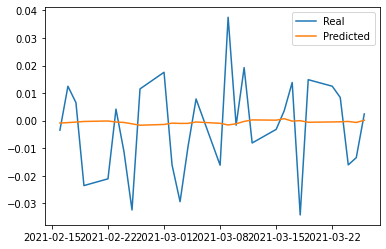

In [46]:
# Plot the real vs predicted prices as a line chart
stocks.plot()